--- Data Sample ---
           area   item  year  rainfall  temperature domain unit  pesticides  \
24  Afghanistan  Maize  1985     327.0        15.52    NaN  NaN         NaN   
25  Afghanistan  Maize  1986     327.0        14.71    NaN  NaN         NaN   
26  Afghanistan  Maize  1987     327.0        15.46    NaN  NaN         NaN   
28  Afghanistan  Maize  1989     327.0        14.46    NaN  NaN         NaN   
29  Afghanistan  Maize  1990     327.0        15.45    NaN  NaN         NaN   

    yield_tonnes_per_ha  
24               1.6652  
25               1.6875  
26               1.7020  
28               1.6963  
29               1.7582  

Final Data Shape: (44120, 9)

Training set size: 35296 samples
Testing set size: 8824 samples

--- Model Performance ---
Mean Absolute Error (MAE): 0.7834 tonnes/ha
R-squared (R2) Score: 0.9529


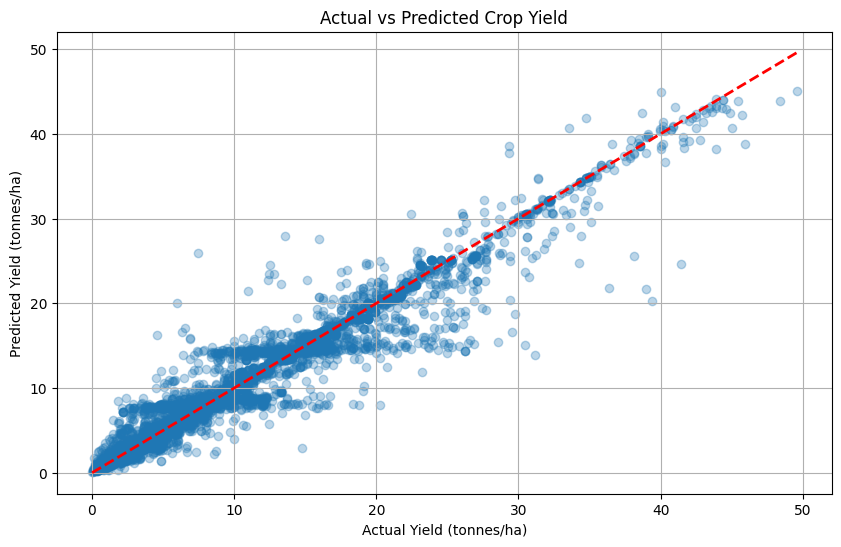

/tmp/ipykernel_25039/3650430038.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_features.values, y=top_20_features.index, palette="mako")


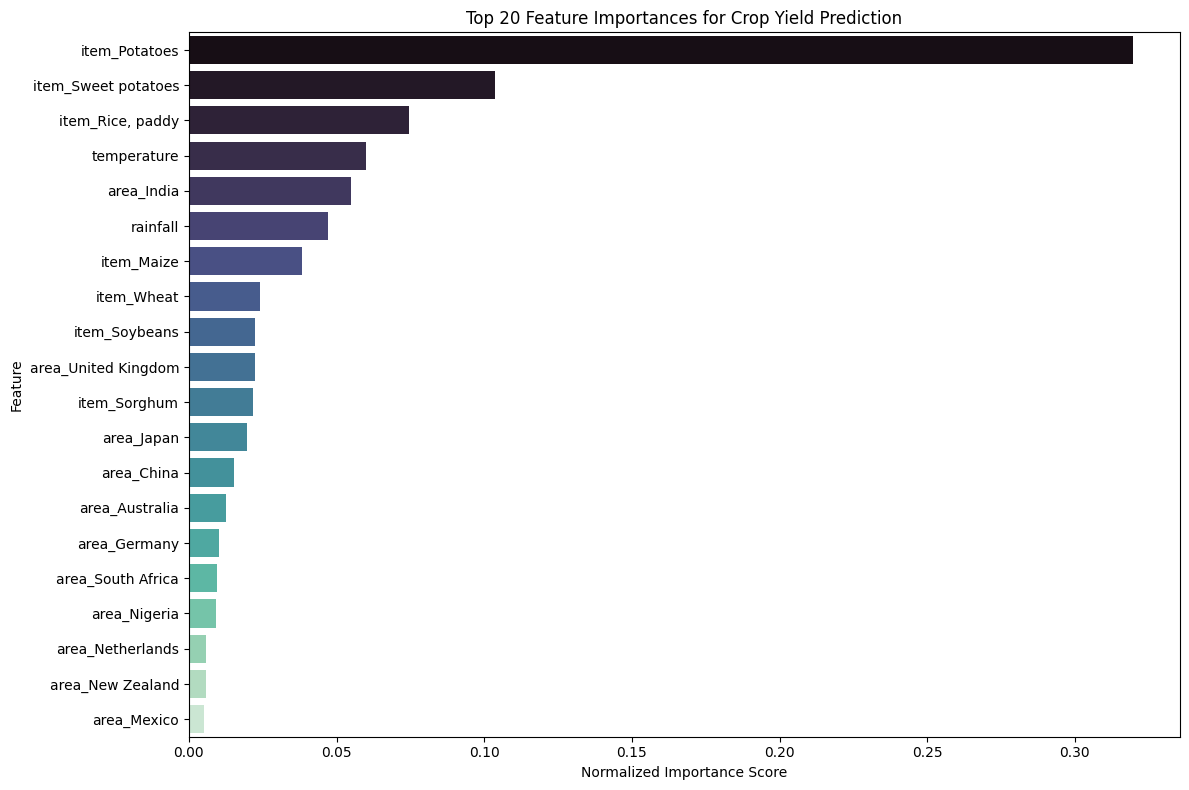

In [1]:
# ==============================================================================
# 1. DATA CLEANING AND MERGING
# ==============================================================================

import pandas as pd

# Load CSVs
df_yield = pd.read_csv('yield.csv')
df_rain = pd.read_csv('rainfall.csv')
df_temp = pd.read_csv('temp.csv')
df_pesticides = pd.read_csv('pesticides.csv')

# Normalize column names
for df in [df_yield, df_rain, df_temp, df_pesticides]:
    df.columns = df.columns.str.strip().str.lower()

# Fix temp dataframe column if necessary
if 'country' in df_temp.columns:
    df_temp.rename(columns={'country': 'area'}, inplace=True)

# Rename target column
df_yield.rename(columns={'value': 'hg/ha_yield'}, inplace=True)

# Drop unnecessary columns in yield
drop_cols = ['year code', 'element code', 'element', 'area code',
             'domain code', 'domain', 'unit', 'item code']
df_yield.drop(columns=[c for c in drop_cols if c in df_yield.columns], inplace=True)

# Rename feature columns
df_rain.rename(columns={'average_rain_fall_mm_per_year': 'rainfall'}, inplace=True)
df_temp.rename(columns={'avg_temp': 'temperature'}, inplace=True)
df_pesticides.rename(columns={'value': 'pesticides'}, inplace=True)
df_pesticides.drop(columns=['element'], inplace=True, errors='ignore')

# Replace '..' and other non-numeric with NaN
for col in ['rainfall','temperature','pesticides','hg/ha_yield']:
    for df_ in [df_rain, df_temp, df_pesticides, df_yield]:
        if col in df_.columns:
            df_[col] = pd.to_numeric(df_[col], errors='coerce')

# Merge datasets
df = pd.merge(df_yield, df_rain, on=['area','year'], how='left')
df = pd.merge(df, df_temp, on=['area','year'], how='left')
if 'item' in df_pesticides.columns and 'item' in df.columns:
    df = pd.merge(df, df_pesticides, on=['area','year','item'], how='left')

# Drop rows with missing numeric features or target
df.dropna(subset=['hg/ha_yield','rainfall','temperature'], inplace=True)

# Feature engineering: convert yield to tonnes/ha
df['yield_tonnes_per_ha'] = df['hg/ha_yield'] / 10000
df.drop(columns=['hg/ha_yield'], inplace=True)

print("--- Data Sample ---")
print(df.head())
print(f"\nFinal Data Shape: {df.shape}")

# ==============================================================================
# 2. FEATURE ENCODING AND MODEL PREPARATION
# ==============================================================================

from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('yield_tonnes_per_ha', axis=1)
y = df['yield_tonnes_per_ha']

# One-Hot Encode categorical variables
categorical_cols = [c for c in ['area','item','year'] if c in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# ==============================================================================
# 3. RANDOM FOREST REGRESSION MODEL TRAINING AND EVALUATION
# ==============================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Performance ---")
print(f"Mean Absolute Error (MAE): {mae:.4f} tonnes/ha")
print(f"R-squared (R2) Score: {r2:.4f}")

# ==============================================================================
# 4. RESULTS VISUALIZATION
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (tonnes/ha)')
plt.ylabel('Predicted Yield (tonnes/ha)')
plt.title('Actual vs Predicted Crop Yield')
plt.grid(True)
plt.show()

# Feature Importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
top_20_features = feature_importances.nlargest(20)

plt.figure(figsize=(12,8))
sns.barplot(x=top_20_features.values, y=top_20_features.index, palette="mako")
plt.title('Top 20 Feature Importances for Crop Yield Prediction')
plt.xlabel('Normalized Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
